In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
import numpy as np

In [27]:
# Convertir le dictionnaire en DataFrame

# df = pd.read_csv('dataset1.csv', sep=';')
df = pd.read_csv('data.csv')
df = df.dropna()

# Remplacer les valeurs dans grading par des int
df["grading"] = [int(x[0]) if x[0].isdigit() and "/" not in x else int(5*float(x.split('/')[0])/float(x.split('/')[1])) for x in df["grading"]]

# Remplace date par un dictionnaire {months: number, years: number}
def transform_date(date):
    weeks_or_days = ['week', 'day', 'semaine', 'jour']
    date_array = date.split()
    if any(word in date_array for word in weeks_or_days):
        return 0
    elif 'month' in date or 'mois' in date:
        if date_array[0].isdigit():
            return int(date_array[0])
        return 1
    elif date_array[0].isdigit():
        return int(date_array[0])*12
    return 12

df["date"] = df["date"].apply(transform_date)

df.index_name = 'ID'
# Renommer la colonne d'index en "ID"
df = df.rename_axis('ID').reset_index()
df.set_index('ID', inplace=True)
# Ajouter la colonne Language à la DataFrame

# Pour que les détections soient consistent
DetectorFactory.seed = 0
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

df['Language'] = df['Text'].apply(detect_language)
df.drop(df.loc[df['Language'] == 'unknown'].index, inplace=True)

df

,Name,grading,date,Text,Language
ID,,,,,
0,Reezaane Bundhoo,4,12,"Delicious cakes, hot/cold beverages and great ...",en
1,Akram Althawbani,5,3,Best place but it's still camels man opinion. ...,en
2,Ibrahim Sobh,4,1,"Amazing place to buy bread and sweets , always...",en
3,Mareike Engel,5,5,Love the baguette and croissant. Staff is alwa...,en
4,shrishail kurangi,3,6,All the items I have tried here are really gre...,en
...,...,...,...,...,...
5009,Ammellle Ammellle,5,48,Salle intimiste très agréable,fr
5010,Amélie Glorian,4,12,Ancien cinéma,fr
5012,jules qci,5,72,Bonne salle rien a dire,fr


## Translation

In [28]:
"""#pip install google-cloud-translate==2.0.1
from google.cloud import translate_v2 as translate
import os, json
from dotenv import load_dotenv
load_dotenv()

CREDENTIALS = json.loads(os.environ.get('CREDENTIALS'))

if os.path.exists('credentials.json'):
    pass
else:
    with open('credentials.json', 'w') as credFile:
        json.dump(CREDENTIALS, credFile)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'credentials.json'

def translate_text(row):
    translate_client = translate.Client()

    text = row['Text']
    if isinstance(text, bytes):
        text = text.decode("utf-8")

    # Only translate the text if the language isn't 'en'.
    if row['Language'] != 'en':
        try:
            result = translate_client.translate(text, target_language='en')
            return pd.Series([result["translatedText"], 'en'])
        except Exception:
            return pd.Series([text, row['Language']])  # if translation fails, return original text and language
    else:
        return pd.Series([text, row['Language']])  # if text is already in English, return original text and language

df[['Text', 'Language']] = df.apply(translate_text, axis=1)
df
"""

from deep_translator import GoogleTranslator

def translate_text(df):
    for i, row in df.iterrows():
        if row['Language'] != 'en':
            text = row['Text']
            translated_text = GoogleTranslator(source='auto', target='en').translate(text)
            df.at[i, 'Text'] = translated_text
            df.at[i, 'Language'] = 'en'
    return df

# Apply the function to the DataFrame
df = translate_text(df)
df

,Name,grading,date,Text,Language
ID,,,,,
0,Reezaane Bundhoo,4,12,"Delicious cakes, hot/cold beverages and great ...",en
1,Akram Althawbani,5,3,Best place but it's still camels man opinion. ...,en
2,Ibrahim Sobh,4,1,"Amazing place to buy bread and sweets , always...",en
3,Mareike Engel,5,5,Love the baguette and croissant. Staff is alwa...,en
4,shrishail kurangi,3,6,All the items I have tried here are really gre...,en
...,...,...,...,...,...
5009,Ammellle Ammellle,5,48,Very pleasant intimate room,en
5010,Amélie Glorian,4,12,old cinema,en
5012,jules qci,5,72,Good room nothing to say,en


## EDA

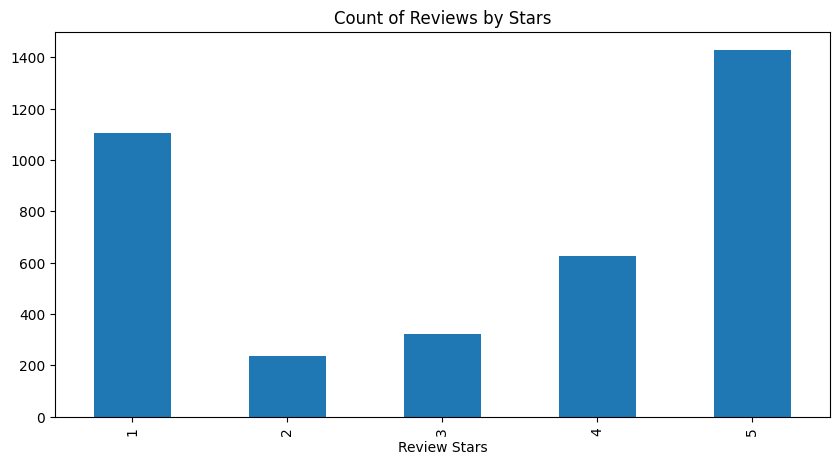

In [29]:
ax = df['grading'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Sentiment Analysis

### Roberta

In [30]:
from transformers import pipeline
from transformers import AutoTokenizer

In [31]:
# Sentiment Analysis with Roberta
"""
nlp = pipeline("sentiment-analysis", model=f"cardiffnlp/twitter-roberta-base-sentiment")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']
    if langue == 'en':
        dict = pd.DataFrame(nlp(text))
        dict['ID'] = index
        res = pd.concat([res, dict], axis=0)
"""
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

nlp = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", tokenizer=tokenizer)

res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']

    # If the language is English and the token length doesn't exceed the limit
    if langue == 'en':
        tokens = tokenizer.encode(text, return_tensors='pt')

        if len(tokens[0]) <= 512:
            dict = pd.DataFrame(nlp(text))
            dict['ID'] = index
            res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res['label'] = res['label'].replace('LABEL_0', 'NEGATIVE')
res['label'] = res['label'].replace('LABEL_1', 'NEUTRAL')
res['label'] = res['label'].replace('LABEL_2', 'POSITIVE')
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={"label": "label (roberta)", "score": "score (roberta)"})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df


,Name,grading,date,Text,Language,label (roberta),score (roberta)
ID,,,,,,,
0,Reezaane Bundhoo,4,12,"Delicious cakes, hot/cold beverages and great ...",en,POSITIVE,0.907862
1,Akram Althawbani,5,3,Best place but it's still camels man opinion. ...,en,POSITIVE,0.809464
2,Ibrahim Sobh,4,1,"Amazing place to buy bread and sweets , always...",en,NEUTRAL,0.368061
3,Mareike Engel,5,5,Love the baguette and croissant. Staff is alwa...,en,POSITIVE,0.991683
4,shrishail kurangi,3,6,All the items I have tried here are really gre...,en,NEGATIVE,0.392930
...,...,...,...,...,...,...,...
5009,Ammellle Ammellle,5,48,Very pleasant intimate room,en,POSITIVE,0.966187
5010,Amélie Glorian,4,12,old cinema,en,NEUTRAL,0.736137
5012,jules qci,5,72,Good room nothing to say,en,POSITIVE,0.725447


## nlptown/bert-base-multilingual-uncased-sentiment

In [32]:
# Sentiment Analysis Bert-base-uncased
# Plusieurs langages disponibles (dont le français)
#English	150k
#Dutch	80k
#German	137k
#French	140k
#Italian	72k
#Spanish
# Il classifie les phrases en étoiles (1 à 5)
# Ce modèle est connu
"""
nlp = pipeline("sentiment-analysis", model=f"nlptown/bert-base-multilingual-uncased-sentiment")

# Run the polarity score on the entire dataset
res = pd.DataFrame(columns=['label', 'score'])
for index, row in df.iterrows():
    text = row['Text']
    langue = row['Language']
    if langue == 'en' or langue == 'fr' or langue == 'es' or langue == 'it' or langue == 'de' or langue == 'nl':

        tokens = tokenizer.encode(text, return_tensors='pt')

        if len(tokens[0]) <= 512:
            dict = pd.DataFrame(nlp(text))
            dict['ID'] = index
            res = pd.concat([res, dict], axis=0)

# Remplacement des valeurs
res['label'] = res['label'].replace('1 star', int(1))
res['label'] = res['label'].replace('2 stars', int(2))
res['label'] = res['label'].replace('3 stars', int(3))
res['label'] = res['label'].replace('4 stars', int(4))
res['label'] = res['label'].replace('5 stars', int(5))
res["ID"] = res['ID'].astype(int)
res = res.rename(columns={'label': 'label (Bert), over 5', 'score': 'score (Bert)'})
res.set_index('ID', inplace=True)

# Merge the two dataframes
df = df.merge(res, left_index=True, right_index=True, how='left')
df
"""
# print(df.isnull().sum())
# print(f"Negative: {df[df['label (roberta)'] == 'NEGATIVE'].count()}, Positive: {df[df['label (roberta)'] == 'POSITIVE'].count()}, Neutral: {df[df['label (roberta)'] == 'NEUTRAL'].count()}")


'\nnlp = pipeline("sentiment-analysis", model=f"nlptown/bert-base-multilingual-uncased-sentiment")\n\n# Run the polarity score on the entire dataset\nres = pd.DataFrame(columns=[\'label\', \'score\'])\nfor index, row in df.iterrows():\n    text = row[\'Text\']\n    langue = row[\'Language\']\n    if langue == \'en\' or langue == \'fr\' or langue == \'es\' or langue == \'it\' or langue == \'de\' or langue == \'nl\':\n\n        tokens = tokenizer.encode(text, return_tensors=\'pt\')\n\n        if len(tokens[0]) <= 512:\n            dict = pd.DataFrame(nlp(text))\n            dict[\'ID\'] = index\n            res = pd.concat([res, dict], axis=0)\n\n# Remplacement des valeurs\nres[\'label\'] = res[\'label\'].replace(\'1 star\', int(1))\nres[\'label\'] = res[\'label\'].replace(\'2 stars\', int(2))\nres[\'label\'] = res[\'label\'].replace(\'3 stars\', int(3))\nres[\'label\'] = res[\'label\'].replace(\'4 stars\', int(4))\nres[\'label\'] = res[\'label\'].replace(\'5 stars\', int(5))\nres["ID"] 

## Using Sklearn

In [33]:
"""
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = df.drop(df[df['label (roberta)'].isna()].index)

# Assume X is your list of texts and y is your list of labels
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['label (roberta)'], test_size=0.2)

# Transform the text data into numerical vectors
vectorizer = CountVectorizer()
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

# Train the classifier
clf = MultinomialNB()
clf.fit(X_train_vectors, y_train)

# Test the classifier
predictions = clf.predict(X_test_vectors)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted', zero_division=0)
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, predictions)

# DISPLAY CONFUSION MATRIX
# Transpose the confusion matrix
cm = cm.T
# Define the labels of the matrix
labels = ['Negative', 'Neutral', 'Positive']
# Create a dataframe from the confusion matrix for easier plotting
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
# Display the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Predicted Label')
plt.xlabel('True Label')
plt.show()
"""

"\nfrom sklearn.feature_extraction.text import CountVectorizer\nfrom sklearn.naive_bayes import MultinomialNB\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score\n\ndf = df.drop(df[df['label (roberta)'].isna()].index)\n\n# Assume X is your list of texts and y is your list of labels\nX_train, X_test, y_train, y_test = train_test_split(df['Text'], df['label (roberta)'], test_size=0.2)\n\n# Transform the text data into numerical vectors\nvectorizer = CountVectorizer()\nX_train_vectors = vectorizer.fit_transform(X_train)\nX_test_vectors = vectorizer.transform(X_test)\n\n# Train the classifier\nclf = MultinomialNB()\nclf.fit(X_train_vectors, y_train)\n\n# Test the classifier\npredictions = clf.predict(X_test_vectors)\n\n# Calculate metrics\naccuracy = accuracy_score(y_test, predictions)\nprecision = precision_score(y_test, predictions, average='weighted', zero_division=0)\nrecall = recall_score(y_test, pr

## Exportation des données

In [34]:
import csv

chemin_fichier = 'processed_data.csv'

# Exporter le DataFrame dans un fichier CSV
df.to_csv(chemin_fichier, index=False)

## Score du modèle

In [35]:
# test_df = pd.read_csv('dataset1.csv', sep=';')
test_df = pd.read_csv('data.csv')
print(test_df.shape)
test_df.head()

(5015, 4)


,Name,grading,date,Text
0,Reezaane Bundhoo,4 stars,a year ago,"Delicious cakes, hot/cold beverages and great ..."
1,Akram Althawbani,5 stars,3 months ago,Best place but it's still camels man opinion. ...
2,Ibrahim Sobh,4 stars,a month ago,"Amazing place to buy bread and sweets , always..."
3,Mareike Engel,5 stars,5 months ago,Love the baguette and croissant. Staff is alwa...
4,shrishail kurangi,3 stars,6 months ago,All the items I have tried here are really gre...


In [36]:
test_df = test_df.dropna()
test_df.shape

(3726, 4)

In [37]:
X_test = test_df['Text']
y_test = test_df['Target']
X_test

KeyError: 'Target'

In [ ]:
# Traduire les phrases en anglais

X_test = X_test.apply(GoogleTranslator(source='auto', target='en').translate)
X_test

In [ ]:
y_pred = X_test.apply(lambda x: nlp(x)[0]['label'])

In [ ]:
# remplacer LABEL_0 par 0, LABEL_1 par 1 et LABEL_2 par 2
y_pred = y_pred.replace('LABEL_0', 0)
y_pred = y_pred.replace('LABEL_1', 1)
y_pred = y_pred.replace('LABEL_2', 2)
y_pred

In [ ]:
def accuracy(y_test, y_pred):
    return np.mean(y_test == y_pred)

In [ ]:
# Remplacer la valeur de la ligne 1515 par 0
y_test = y_test.replace('À', 0)

In [ ]:
y_pred = y_pred.astype(int)
y_test = y_test.astype(int)

In [ ]:
score = accuracy(y_test, y_pred)
print(f"Accuracy: {score:.2f}")